In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.0003
weight_decay = 0.0005

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2, step3])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 211)
(10000, 211)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 211])
torch.Size([10000, 211])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(211, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(num_features=512)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(num_features=512)
        
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(num_features=128)
        
        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(num_features=64)
        
        self.fc7 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(num_features=32)
        
        self.fc8 = nn.Linear(32, 1)
        
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)

        return x

In [17]:
model = DNN().to(device)
model.apply(weights_init_uniform)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [19]:
#train_losses = []
#eval_losses = []
#accs = []
for t in range(2000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 6.75363528329913
epochs 1
training loss 3.6869358552625475
epochs 2
training loss 1.1813627465608272
epochs 3
training loss 0.13784821392645588
epochs 4
training loss 0.0691052162425315
epochs 5
training loss 0.041945271728996265
epochs 6
training loss 0.033604479621314534
epochs 7
training loss 0.028863234027914454
epochs 8
training loss 0.027894222194549703
epochs 9
training loss 0.026340313208371536
testing loss 0.017205774757667637
epochs 10
training loss 0.025927641789929935
epochs 11
training loss 0.024666568632364997
epochs 12
training loss 0.02345344823739834
epochs 13
training loss 0.023495212543365125
epochs 14
training loss 0.021514452822608335
epochs 15
training loss 0.02159960110782218
epochs 16
training loss 0.02081311467998183
epochs 17
training loss 0.02054332399112385
epochs 18
training loss 0.021119379955074978
epochs 19
training loss 0.01892864763932048
testing loss 0.04147569840470104
epochs 20
training loss 0.01844585027990121
epochs 21
train

training loss 0.005168740677938862
testing loss 0.015239170237266004
epochs 170
training loss 0.005216853882435223
epochs 171
training loss 0.005114225293495508
epochs 172
training loss 0.005171938462106449
epochs 173
training loss 0.005114019021468299
epochs 174
training loss 0.0051220076821750105
epochs 175
training loss 0.0050507204477621475
epochs 176
training loss 0.0050807637219121935
epochs 177
training loss 0.005081992598864785
epochs 178
training loss 0.005140461270360553
epochs 179
training loss 0.005090730121829136
testing loss 0.010922608286115928
epochs 180
training loss 0.0053989498272374
epochs 181
training loss 0.005199334064730667
epochs 182
training loss 0.005261849211090128
epochs 183
training loss 0.005161168580622862
epochs 184
training loss 0.00512668860214267
epochs 185
training loss 0.004973837641198018
epochs 186
training loss 0.005039150042864169
epochs 187
training loss 0.005109140457299546
epochs 188
training loss 0.005096160901546206
epochs 189
training los

training loss 0.004257697038816736
epochs 336
training loss 0.004320853593261024
epochs 337
training loss 0.004243422692392508
epochs 338
training loss 0.004268712791583096
epochs 339
training loss 0.004205928928230105
testing loss 0.0076681173915135944
epochs 340
training loss 0.004278396059529669
epochs 341
training loss 0.004285195032431883
epochs 342
training loss 0.00433009425369247
epochs 343
training loss 0.004137673554305089
epochs 344
training loss 0.004262539542543399
epochs 345
training loss 0.004377872917000035
epochs 346
training loss 0.004211352106628198
epochs 347
training loss 0.004356747639993924
epochs 348
training loss 0.004182690762671271
epochs 349
training loss 0.004222691936296691
testing loss 0.0061414563972238745
epochs 350
training loss 0.004258737520040168
epochs 351
training loss 0.004308115394069816
epochs 352
training loss 0.004210405452261852
epochs 353
training loss 0.0043032719292975165
epochs 354
training loss 0.004207802246081272
epochs 355
training l

training loss 0.0036154675787869604
epochs 501
training loss 0.003697183506498198
epochs 502
training loss 0.0037118727362525045
epochs 503
training loss 0.0035230986417291014
epochs 504
training loss 0.003563648540920105
epochs 505
training loss 0.003627714103351044
epochs 506
training loss 0.0036897945502988067
epochs 507
training loss 0.0036538760694406224
epochs 508
training loss 0.0036287278338196748
epochs 509
training loss 0.003705689505925883
testing loss 0.0067873492734572775
epochs 510
training loss 0.0037396260583914794
epochs 511
training loss 0.0036906728472866366
epochs 512
training loss 0.003615891594173653
epochs 513
training loss 0.0036128352160528757
epochs 514
training loss 0.0036955813641623117
epochs 515
training loss 0.0036896622819701454
epochs 516
training loss 0.003546137547072329
epochs 517
training loss 0.0036535120695138684
epochs 518
training loss 0.0036733797825674744
epochs 519
training loss 0.0036487688620413417
testing loss 0.005805859216720077
epochs 5

training loss 0.0032388348713386973
epochs 666
training loss 0.0033234494864249936
epochs 667
training loss 0.003435226595368927
epochs 668
training loss 0.0032945539006867127
epochs 669
training loss 0.003294582855548019
testing loss 0.004451914839050237
epochs 670
training loss 0.003244652338877977
epochs 671
training loss 0.0033818552947085137
epochs 672
training loss 0.003196388639801247
epochs 673
training loss 0.003303011363417499
epochs 674
training loss 0.0033659651789865186
epochs 675
training loss 0.0033077198653241285
epochs 676
training loss 0.0032545505042009533
epochs 677
training loss 0.003372040595986674
epochs 678
training loss 0.003427491795786835
epochs 679
training loss 0.0033583810123385674
testing loss 0.004306671319443548
epochs 680
training loss 0.003335462836760994
epochs 681
training loss 0.0033224387732008896
epochs 682
training loss 0.0033587874826270306
epochs 683
training loss 0.0032674381792500025
epochs 684
training loss 0.003278321491010872
epochs 685
t

training loss 0.0030583095362432594
epochs 831
training loss 0.003025151875172954
epochs 832
training loss 0.0030374660777313053
epochs 833
training loss 0.0030359489849264704
epochs 834
training loss 0.0030341553455784827
epochs 835
training loss 0.003133777999970213
epochs 836
training loss 0.003043459775775535
epochs 837
training loss 0.0029856168309730508
epochs 838
training loss 0.002996792938768309
epochs 839
training loss 0.003031512201157905
testing loss 0.005581233072497532
epochs 840
training loss 0.0030192770102800163
epochs 841
training loss 0.00293480349445608
epochs 842
training loss 0.002999175578429389
epochs 843
training loss 0.0030226821241203954
epochs 844
training loss 0.0029846547864303898
epochs 845
training loss 0.003156128692607704
epochs 846
training loss 0.0030047066642769744
epochs 847
training loss 0.002968833193686822
epochs 848
training loss 0.0029251340604712762
epochs 849
training loss 0.0030057456844704267
testing loss 0.005663208125145934
epochs 850
tr

training loss 0.0024914055939559967
epochs 996
training loss 0.0023942949477863415
epochs 997
training loss 0.002400073028200711
epochs 998
training loss 0.002378222779731767
epochs 999
training loss 0.0023748011987848846
testing loss 0.004033724556128818
epochs 1000
training loss 0.002427139066125756
epochs 1001
training loss 0.002610973730551696
epochs 1002
training loss 0.0025245739762051354
epochs 1003
training loss 0.0023573868781311216
epochs 1004
training loss 0.0024600481235147608
epochs 1005
training loss 0.0026381639636328335
epochs 1006
training loss 0.002318174876541601
epochs 1007
training loss 0.002347903499184431
epochs 1008
training loss 0.0023155520959561946
epochs 1009
training loss 0.002396650166685288
testing loss 0.0064159702189293105
epochs 1010
training loss 0.0022764765685084516
epochs 1011
training loss 0.002359038990947749
epochs 1012
training loss 0.002336338783067999
epochs 1013
training loss 0.0023166633157645517
epochs 1014
training loss 0.0025242905547887

training loss 0.0020247426338346622
epochs 1157
training loss 0.002074475925257231
epochs 1158
training loss 0.0020680683121824
epochs 1159
training loss 0.002144827846420708
testing loss 0.004162722103733649
epochs 1160
training loss 0.0021021549101978383
epochs 1161
training loss 0.0020294413278388896
epochs 1162
training loss 0.002060869666372672
epochs 1163
training loss 0.0020772895390397126
epochs 1164
training loss 0.002107364043103684
epochs 1165
training loss 0.0021390351838372805
epochs 1166
training loss 0.002074826309899021
epochs 1167
training loss 0.0021030555835197537
epochs 1168
training loss 0.002116067362963406
epochs 1169
training loss 0.0021363541285371506
testing loss 0.0037247273362578546
epochs 1170
training loss 0.0020532609548456512
epochs 1171
training loss 0.002089193326988651
epochs 1172
training loss 0.0021778512963710923
epochs 1173
training loss 0.002134314808275517
epochs 1174
training loss 0.002110807765784778
epochs 1175
training loss 0.002103131134055

training loss 0.001975555395379119
epochs 1319
training loss 0.001983436620666852
testing loss 0.0032189938120861005
epochs 1320
training loss 0.001996113862460168
epochs 1321
training loss 0.0019442144198212941
epochs 1322
training loss 0.0019519454631515662
epochs 1323
training loss 0.001960197481323928
epochs 1324
training loss 0.0020283418801318753
epochs 1325
training loss 0.00197747988377961
epochs 1326
training loss 0.0018919691037228132
epochs 1327
training loss 0.001964973743317088
epochs 1328
training loss 0.001952029890621415
epochs 1329
training loss 0.001940896932218269
testing loss 0.00392698057009079
epochs 1330
training loss 0.0020091381071894046
epochs 1331
training loss 0.0018716774536593956
epochs 1332
training loss 0.0019034312223791964
epochs 1333
training loss 0.001968288594944612
epochs 1334
training loss 0.001963729532803536
epochs 1335
training loss 0.001941499892639217
epochs 1336
training loss 0.0018973619178911292
epochs 1337
training loss 0.0018951190542854

training loss 0.0018276419024560657
testing loss 0.003871247135201826
epochs 1480
training loss 0.0018063480443870337
epochs 1481
training loss 0.0018470239748408321
epochs 1482
training loss 0.0018701436623327977
epochs 1483
training loss 0.0019525063907413385
epochs 1484
training loss 0.0017965547184921281
epochs 1485
training loss 0.0018126566345537348
epochs 1486
training loss 0.0019146522443733067
epochs 1487
training loss 0.0018834497931407691
epochs 1488
training loss 0.0018448805477891943
epochs 1489
training loss 0.0017907786316459144
testing loss 0.0033769151385781085
epochs 1490
training loss 0.0017835086048439168
epochs 1491
training loss 0.0018605559251885465
epochs 1492
training loss 0.0018591377160534558
epochs 1493
training loss 0.0018562273358385501
epochs 1494
training loss 0.001809635319206354
epochs 1495
training loss 0.0018482048255193265
epochs 1496
training loss 0.001785400088792978
epochs 1497
training loss 0.0018755430564437185
epochs 1498
training loss 0.00181

training loss 0.0017755371440586981
testing loss 0.004070308135412898
epochs 1640
training loss 0.0016902067642276795
epochs 1641
training loss 0.0017201250575066723
epochs 1642
training loss 0.001764839492443847
epochs 1643
training loss 0.0018249888386716075
epochs 1644
training loss 0.0017094353467259997
epochs 1645
training loss 0.0017508845307473602
epochs 1646
training loss 0.0017622557591143032
epochs 1647
training loss 0.001834434547354
epochs 1648
training loss 0.0017969477270647748
epochs 1649
training loss 0.001775991568613605
testing loss 0.0032649704416989225
epochs 1650
training loss 0.0018627411814330084
epochs 1651
training loss 0.0017381781493851457
epochs 1652
training loss 0.0018273227029666872
epochs 1653
training loss 0.0017180796247329507
epochs 1654
training loss 0.0017409875014468485
epochs 1655
training loss 0.0017200326331180597
epochs 1656
training loss 0.0017039327504322793
epochs 1657
training loss 0.001742488120068261
epochs 1658
training loss 0.0017918030

training loss 0.0016669150637207966
epochs 1801
training loss 0.0016903120914324098
epochs 1802
training loss 0.0016354081729755348
epochs 1803
training loss 0.0016956569688496574
epochs 1804
training loss 0.0016594160120654003
epochs 1805
training loss 0.0016783671067903063
epochs 1806
training loss 0.0016820299324839967
epochs 1807
training loss 0.0016956477554084727
epochs 1808
training loss 0.001728258567535259
epochs 1809
training loss 0.0017121750703944874
testing loss 0.0043065342119174965
epochs 1810
training loss 0.0016567199377733705
epochs 1811
training loss 0.0017680348515281266
epochs 1812
training loss 0.0016324241126542147
epochs 1813
training loss 0.0016763282608591857
epochs 1814
training loss 0.0016863243181985948
epochs 1815
training loss 0.00169464341955016
epochs 1816
training loss 0.0016447724710787592
epochs 1817
training loss 0.0017450294221360745
epochs 1818
training loss 0.0017228494617680377
epochs 1819
training loss 0.0016262201347464757
testing loss 0.00371

training loss 0.0018912405258619247
epochs 1961
training loss 0.0015982482191330915
epochs 1962
training loss 0.0015479877932948318
epochs 1963
training loss 0.0015573632934535529
epochs 1964
training loss 0.0016245969192911856
epochs 1965
training loss 0.0015906547332440125
epochs 1966
training loss 0.0016253402311210505
epochs 1967
training loss 0.0015899513614233752
epochs 1968
training loss 0.0015997368595378875
epochs 1969
training loss 0.0015982861845049226
testing loss 0.003378158560722855
epochs 1970
training loss 0.0015748200715536473
epochs 1971
training loss 0.0015961691366698264
epochs 1972
training loss 0.0016134559885615705
epochs 1973
training loss 0.0016514126479973887
epochs 1974
training loss 0.0016344223489226225
epochs 1975
training loss 0.0016068384988307048
epochs 1976
training loss 0.0016110783114131981
epochs 1977
training loss 0.001650343708358535
epochs 1978
training loss 0.0015425764669672697
epochs 1979
training loss 0.0015945589073613784
testing loss 0.0030

training loss 0.0015876263853850405
epochs 2121
training loss 0.0015160981137560267
epochs 2122
training loss 0.001489839006334226
epochs 2123
training loss 0.0016300150891765952
epochs 2124
training loss 0.0015407221927519854
epochs 2125
training loss 0.0015605451595066483
epochs 2126
training loss 0.0015125388964603013
epochs 2127
training loss 0.0015336639714203662
epochs 2128
training loss 0.0015076765433904972
epochs 2129
training loss 0.001572675720256354
testing loss 0.0030906929478465403
epochs 2130
training loss 0.0015935609683303848
epochs 2131
training loss 0.0015494019970705443
epochs 2132
training loss 0.0015489950666054064
epochs 2133
training loss 0.0015368543446381041
epochs 2134
training loss 0.0015598337976672435
epochs 2135
training loss 0.0015457194819720886
epochs 2136
training loss 0.001563748131586822
epochs 2137
training loss 0.001558790852083601
epochs 2138
training loss 0.0015363935657173938
epochs 2139
training loss 0.001580017766565662
testing loss 0.0028389

training loss 0.0014562702725010167
epochs 2282
training loss 0.0014114439008703688
epochs 2283
training loss 0.0014191433278869237
epochs 2284
training loss 0.001484029012198608
epochs 2285
training loss 0.0015125899843865932
epochs 2286
training loss 0.001559338831918818
epochs 2287
training loss 0.0014488993803149592
epochs 2288
training loss 0.0014493973010310218
epochs 2289
training loss 0.001493961932095147
testing loss 0.0031059852137448308
epochs 2290
training loss 0.001436452047105335
epochs 2291
training loss 0.0015098992931531986
epochs 2292
training loss 0.0014529699685425698
epochs 2293
training loss 0.0015064047804841131
epochs 2294
training loss 0.0014736342182281033
epochs 2295
training loss 0.0014593856823899554
epochs 2296
training loss 0.0015145237545205398
epochs 2297
training loss 0.0014868209224851027
epochs 2298
training loss 0.0014287729809162601
epochs 2299
training loss 0.001529375814456255
testing loss 0.0028415130045106435
epochs 2300
training loss 0.0015267

training loss 0.0014638206795902532
epochs 2442
training loss 0.0014293347941824776
epochs 2443
training loss 0.0015174630464275445
epochs 2444
training loss 0.0014282316385236169
epochs 2445
training loss 0.001385176083353266
epochs 2446
training loss 0.0014422521399232164
epochs 2447
training loss 0.0014500696474607003
epochs 2448
training loss 0.001418541810095967
epochs 2449
training loss 0.0014095251966129117
testing loss 0.0030031565210207347
epochs 2450
training loss 0.0013923211482149693
epochs 2451
training loss 0.0014266310115330669
epochs 2452
training loss 0.0014646995655546887
epochs 2453
training loss 0.0014225816827247593
epochs 2454
training loss 0.0014790268699811223
epochs 2455
training loss 0.0014755192193652766
epochs 2456
training loss 0.001402426564833857
epochs 2457
training loss 0.0014894665312658894
epochs 2458
training loss 0.0014105510309134755
epochs 2459
training loss 0.0014558544498868287
testing loss 0.0034304921769583267
epochs 2460
training loss 0.00150

training loss 0.0014108229624206557
epochs 2602
training loss 0.0013431283347393559
epochs 2603
training loss 0.0013198103303851214
epochs 2604
training loss 0.0013760768641763025
epochs 2605
training loss 0.0013968467531587057
epochs 2606
training loss 0.001355755346152071
epochs 2607
training loss 0.0013572162568872075
epochs 2608
training loss 0.0013984070804556068
epochs 2609
training loss 0.0013615700308697745
testing loss 0.0028435107318895824
epochs 2610
training loss 0.001338426872775083
epochs 2611
training loss 0.0013792020801984136
epochs 2612
training loss 0.0013395214538616453
epochs 2613
training loss 0.001389403439142478
epochs 2614
training loss 0.0013990325960797742
epochs 2615
training loss 0.0013589486134759402
epochs 2616
training loss 0.0013940681062573651
epochs 2617
training loss 0.001413043397853836
epochs 2618
training loss 0.0013662145022263236
epochs 2619
training loss 0.0014013210394685821
testing loss 0.0028727940838546196
epochs 2620
training loss 0.001352

training loss 0.0013186246355553937
epochs 2762
training loss 0.0013870532192023738
epochs 2763
training loss 0.0013188925723185746
epochs 2764
training loss 0.0013488687197663637
epochs 2765
training loss 0.0013129611778792028
epochs 2766
training loss 0.0013268693096547934
epochs 2767
training loss 0.0013259595867223743
epochs 2768
training loss 0.0013011068795343414
epochs 2769
training loss 0.0013088068972967315
testing loss 0.0029623750588982133
epochs 2770
training loss 0.0013114569098674508
epochs 2771
training loss 0.001385861393460568
epochs 2772
training loss 0.0013416317747311389
epochs 2773
training loss 0.0013449032471435976
epochs 2774
training loss 0.001315060227693237
epochs 2775
training loss 0.001372764294324471
epochs 2776
training loss 0.0013588258876652093
epochs 2777
training loss 0.0012964983430045647
epochs 2778
training loss 0.0013731802475078195
epochs 2779
training loss 0.0013282067369949921
testing loss 0.0030573087931009576
epochs 2780
training loss 0.00135

training loss 0.0012705717872726337
epochs 2922
training loss 0.001303727547659349
epochs 2923
training loss 0.001271987018263177
epochs 2924
training loss 0.0012384799401428674
epochs 2925
training loss 0.0012742601270294865
epochs 2926
training loss 0.0013142548903814406
epochs 2927
training loss 0.0012482654971727326
epochs 2928
training loss 0.0013141051793929563
epochs 2929
training loss 0.0012762418809760146
testing loss 0.0026204032457684636
epochs 2930
training loss 0.0012582830619774646
epochs 2931
training loss 0.0013017277525225514
epochs 2932
training loss 0.001308934774220069
epochs 2933
training loss 0.0012554568311094808
epochs 2934
training loss 0.0012668248076320237
epochs 2935
training loss 0.0012816966144724728
epochs 2936
training loss 0.0012882436676259438
epochs 2937
training loss 0.001285568862130135
epochs 2938
training loss 0.0013492102028821852
epochs 2939
training loss 0.0012856054850103825
testing loss 0.0027824764392596294
epochs 2940
training loss 0.001336

training loss 0.0012842121894618547
epochs 3083
training loss 0.0012225884417677723
epochs 3084
training loss 0.0011941901882997173
epochs 3085
training loss 0.0012517419682977024
epochs 3086
training loss 0.001255654330764498
epochs 3087
training loss 0.0012826949015109711
epochs 3088
training loss 0.0012820467500067048
epochs 3089
training loss 0.0012117701706102848
testing loss 0.0028491599847734342
epochs 3090
training loss 0.0012080700851136133
epochs 3091
training loss 0.001212338423519183
epochs 3092
training loss 0.001248381496194784
epochs 3093
training loss 0.0012362774652230771
epochs 3094
training loss 0.0012275894973243057
epochs 3095
training loss 0.0012435145410043852
epochs 3096
training loss 0.0012374424498024365
epochs 3097
training loss 0.0012280109351200808
epochs 3098
training loss 0.001252417001125932
epochs 3099
training loss 0.0011685697542642183
testing loss 0.002745084067004079
epochs 3100
training loss 0.0012621832855815765
epochs 3101
training loss 0.0012612

training loss 0.0012574766312816426
epochs 3244
training loss 0.0011963657723417036
epochs 3245
training loss 0.0012941278851984527
epochs 3246
training loss 0.001192769603088985
epochs 3247
training loss 0.0011621990784617725
epochs 3248
training loss 0.0011673095601746717
epochs 3249
training loss 0.0012142295490222838
testing loss 0.0035192286917702
epochs 3250
training loss 0.0011588935179446221
epochs 3251
training loss 0.001238538416372867
epochs 3252
training loss 0.001185333856599445
epochs 3253
training loss 0.0011932996484184904
epochs 3254
training loss 0.001194066241366568
epochs 3255
training loss 0.0012211977422101519
epochs 3256
training loss 0.0011706452423601913
epochs 3257
training loss 0.0011428841336638778
epochs 3258
training loss 0.0012105326286777514
epochs 3259
training loss 0.0012208014587931177
testing loss 0.002807718115455821
epochs 3260
training loss 0.0011781349066591123
epochs 3261
training loss 0.0011839373592757209
epochs 3262
training loss 0.0012319229

training loss 0.001228169044111728
epochs 3404
training loss 0.001153988485036299
epochs 3405
training loss 0.0011598769197449948
epochs 3406
training loss 0.0011590539854965357
epochs 3407
training loss 0.0011992248234842936
epochs 3408
training loss 0.001155136104801947
epochs 3409
training loss 0.001188200224038089
testing loss 0.002778744112026501
epochs 3410
training loss 0.0011864106364033007
epochs 3411
training loss 0.00115574684204947
epochs 3412
training loss 0.001144957150499645
epochs 3413
training loss 0.001175900576048811
epochs 3414
training loss 0.0011506655699669703
epochs 3415
training loss 0.0011914534930219042
epochs 3416
training loss 0.0011494107598206736
epochs 3417
training loss 0.0011569935604462847
epochs 3418
training loss 0.0011528584922842206
epochs 3419
training loss 0.0012168291618971092
testing loss 0.0028286919646718085
epochs 3420
training loss 0.0011801794650794593
epochs 3421
training loss 0.0011900155371590022
epochs 3422
training loss 0.00114456709

training loss 0.0011235413641886825
epochs 3565
training loss 0.0011481616734866744
epochs 3566
training loss 0.0011485703255893452
epochs 3567
training loss 0.001133208780013036
epochs 3568
training loss 0.0011607597654226794
epochs 3569
training loss 0.0011088168112303508
testing loss 0.0028004823190635663
epochs 3570
training loss 0.001125174217169544
epochs 3571
training loss 0.0011285928972872218
epochs 3572
training loss 0.0011177284617930946
epochs 3573
training loss 0.0011579512017297821
epochs 3574
training loss 0.0011300796322315071
epochs 3575
training loss 0.0012085506937390131
epochs 3576
training loss 0.0011437961123643109
epochs 3577
training loss 0.0011342498081054052
epochs 3578
training loss 0.0011243697259034453
epochs 3579
training loss 0.0011459258077156625
testing loss 0.003317658548368841
epochs 3580
training loss 0.0011317725781645727
epochs 3581
training loss 0.001119825470269768
epochs 3582
training loss 0.0011082656029045672
epochs 3583
training loss 0.001144

training loss 0.0011061076658684477
epochs 3725
training loss 0.001110262642289005
epochs 3726
training loss 0.0011130997121665276
epochs 3727
training loss 0.001105595718344566
epochs 3728
training loss 0.001111159695766719
epochs 3729
training loss 0.0012824909146209912
testing loss 0.0032034476150606646
epochs 3730
training loss 0.001168774632669102
epochs 3731
training loss 0.0010844271909233216
epochs 3732
training loss 0.0011286272491840786
epochs 3733
training loss 0.0010871658327077773
epochs 3734
training loss 0.0010875873920496407
epochs 3735
training loss 0.0011640803051240585
epochs 3736
training loss 0.001091660391737489
epochs 3737
training loss 0.001091391088244276
epochs 3738
training loss 0.0011071588151938194
epochs 3739
training loss 0.0011022766863808353
testing loss 0.003019488889704201
epochs 3740
training loss 0.0011262326550140615
epochs 3741
training loss 0.0010711112633590956
epochs 3742
training loss 0.0011128930197703145
epochs 3743
training loss 0.001162000

training loss 0.0010541578663490418
epochs 3885
training loss 0.001083493938295901
epochs 3886
training loss 0.0010812014247939036
epochs 3887
training loss 0.0010908181304225308
epochs 3888
training loss 0.0011069768815765604
epochs 3889
training loss 0.0010697667256611935
testing loss 0.002776616438727905
epochs 3890
training loss 0.0010933491311497466
epochs 3891
training loss 0.0010626146425301985
epochs 3892
training loss 0.001121127646944364
epochs 3893
training loss 0.0010702787285619684
epochs 3894
training loss 0.0010404345943199013
epochs 3895
training loss 0.0011214758996642266
epochs 3896
training loss 0.0010839636111348912
epochs 3897
training loss 0.0011332193973380789
epochs 3898
training loss 0.001063956169618186
epochs 3899
training loss 0.0012405185121972125
testing loss 0.0033824625045246054
epochs 3900
training loss 0.0011405993805346179
epochs 3901
training loss 0.001054484461572893
epochs 3902
training loss 0.0010854994793603689
epochs 3903
training loss 0.0010863

training loss 0.0010850881495283729
epochs 4046
training loss 0.001193349430653179
epochs 4047
training loss 0.001168591362221795
epochs 4048
training loss 0.0010428703768677035
epochs 4049
training loss 0.0010594301106900792
testing loss 0.002864815150668303
epochs 4050
training loss 0.0010427032189732446
epochs 4051
training loss 0.0010087838864214378
epochs 4052
training loss 0.0010602467314419436
epochs 4053
training loss 0.0010884105203826104
epochs 4054
training loss 0.0010251229275782285
epochs 4055
training loss 0.00105560519240689
epochs 4056
training loss 0.00104397870734685
epochs 4057
training loss 0.0010070848522147327
epochs 4058
training loss 0.001107622604635983
epochs 4059
training loss 0.0010385306169545011
testing loss 0.002616605458034744
epochs 4060
training loss 0.001029376103772745
epochs 4061
training loss 0.0010205459408391278
epochs 4062
training loss 0.0010496115085164984
epochs 4063
training loss 0.001096564537907829
epochs 4064
training loss 0.0010349486319

training loss 0.0010070291037832621
epochs 4206
training loss 0.0010232838275162984
epochs 4207
training loss 0.0010168032023962304
epochs 4208
training loss 0.0010090439614350128
epochs 4209
training loss 0.0010586078059335881
testing loss 0.003404637743349035
epochs 4210
training loss 0.0010501063905803537
epochs 4211
training loss 0.001019056662892368
epochs 4212
training loss 0.0009975447910370752
epochs 4213
training loss 0.0009867517804121174
epochs 4214
training loss 0.0010180278432818759
epochs 4215
training loss 0.0010536185134553257
epochs 4216
training loss 0.001048028145847406
epochs 4217
training loss 0.0010567779320512975
epochs 4218
training loss 0.001051482985484043
epochs 4219
training loss 0.00100840904836976
testing loss 0.002865453309326677
epochs 4220
training loss 0.0010589733002403054
epochs 4221
training loss 0.0010249182950962889
epochs 4222
training loss 0.0010354377875687684
epochs 4223
training loss 0.0010455471033932453
epochs 4224
training loss 0.001044556

training loss 0.0010000102138458143
epochs 4367
training loss 0.000978640587802263
epochs 4368
training loss 0.001027601809802785
epochs 4369
training loss 0.0009896136277339684
testing loss 0.0026867621147291776
epochs 4370
training loss 0.0010445643392232979
epochs 4371
training loss 0.0010266371236230872
epochs 4372
training loss 0.0010059321756364275
epochs 4373
training loss 0.0010028688054309596
epochs 4374
training loss 0.0009728913318569627
epochs 4375
training loss 0.0010303473353066048
epochs 4376
training loss 0.001015633455404055
epochs 4377
training loss 0.001010856633361197
epochs 4378
training loss 0.001024592845802589
epochs 4379
training loss 0.0009652831578219599
testing loss 0.00288767302623481
epochs 4380
training loss 0.0010351225401849507
epochs 4381
training loss 0.0010124729848240352
epochs 4382
training loss 0.0010240381648325245
epochs 4383
training loss 0.0009871840664174261
epochs 4384
training loss 0.0009996063135405803
epochs 4385
training loss 0.001041470

training loss 0.000946751605870774
epochs 4528
training loss 0.0009919900495253253
epochs 4529
training loss 0.0010246166815743485
testing loss 0.0027066029493485622
epochs 4530
training loss 0.001102267391908925
epochs 4531
training loss 0.0009837062922546974
epochs 4532
training loss 0.0009932666036829715
epochs 4533
training loss 0.0010068335318810513
epochs 4534
training loss 0.0010004124431134877
epochs 4535
training loss 0.0010787332389789624
epochs 4536
training loss 0.0009843804530295511
epochs 4537
training loss 0.0010217354265975804
epochs 4538
training loss 0.0009756592740333076
epochs 4539
training loss 0.001016331675581317
testing loss 0.002663451426081254
epochs 4540
training loss 0.0009591114807429534
epochs 4541
training loss 0.001014196521271371
epochs 4542
training loss 0.0009823564245750544
epochs 4543
training loss 0.0009749327732482217
epochs 4544
training loss 0.0009861031230850468
epochs 4545
training loss 0.0010248860079790877
epochs 4546
training loss 0.0010003

training loss 0.0009425413335877326
epochs 4689
training loss 0.0009566040226261168
testing loss 0.0027161718404799013
epochs 4690
training loss 0.0009944164981473928
epochs 4691
training loss 0.0009878116003789665
epochs 4692
training loss 0.0009623255690709775
epochs 4693
training loss 0.0009471548685455825
epochs 4694
training loss 0.0009684988027183752
epochs 4695
training loss 0.0009477013089739375
epochs 4696
training loss 0.001021709641930718
epochs 4697
training loss 0.0009792907520708286
epochs 4698
training loss 0.0010212911460987409
epochs 4699
training loss 0.0009713340483430354
testing loss 0.0026931655696421494
epochs 4700
training loss 0.000979360550840875
epochs 4701
training loss 0.000977135679860087
epochs 4702
training loss 0.0009691488110293325
epochs 4703
training loss 0.0010289478856690885
epochs 4704
training loss 0.0009618898309444538
epochs 4705
training loss 0.0009680196892690921
epochs 4706
training loss 0.0009758114531858453
epochs 4707
training loss 0.00097

training loss 0.0009509700758801631
epochs 4849
training loss 0.0009475675559076155
testing loss 0.0027821690573997743
epochs 4850
training loss 0.0009591683443199764
epochs 4851
training loss 0.0009278465036018313
epochs 4852
training loss 0.0009761459527977411
epochs 4853
training loss 0.0009586729695256177
epochs 4854
training loss 0.0010048687951830372
epochs 4855
training loss 0.0010221762830174973
epochs 4856
training loss 0.0009618637537354417
epochs 4857
training loss 0.0010031737174165058
epochs 4858
training loss 0.0009482525305689446
epochs 4859
training loss 0.0009983663022939942
testing loss 0.002704567655736039
epochs 4860
training loss 0.0009545729785561732
epochs 4861
training loss 0.0009419699745305097
epochs 4862
training loss 0.0009834005205119228
epochs 4863
training loss 0.0009482986558940669
epochs 4864
training loss 0.0009704743946143808
epochs 4865
training loss 0.0009374258637967545
epochs 4866
training loss 0.0009520184142532048
epochs 4867
training loss 0.000

training loss 0.000951410603488719
epochs 5009
training loss 0.0009398396233256658
testing loss 0.002606444034381961
epochs 5010
training loss 0.0009423992163105372
epochs 5011
training loss 0.0009309862951583889
epochs 5012
training loss 0.0009506516497211366
epochs 5013
training loss 0.0008890793508762284
epochs 5014
training loss 0.0009842740478330945
epochs 5015
training loss 0.0009560294712590773
epochs 5016
training loss 0.0009318190872015312
epochs 5017
training loss 0.0009287698239499935
epochs 5018
training loss 0.000928624576816794
epochs 5019
training loss 0.0009471020980817365
testing loss 0.0027465430535838433
epochs 5020
training loss 0.0009455475841201616
epochs 5021
training loss 0.0009521650550971912
epochs 5022
training loss 0.0009476822711765132
epochs 5023
training loss 0.0009859598514738587
epochs 5024
training loss 0.0009225445854729523
epochs 5025
training loss 0.0009162833772268497
epochs 5026
training loss 0.0009739343910251594
epochs 5027
training loss 0.00098

training loss 0.000907241028084598
epochs 5169
training loss 0.0009483472761870744
testing loss 0.0029819826752356922
epochs 5170
training loss 0.0009349045992296721
epochs 5171
training loss 0.0009301753707072984
epochs 5172
training loss 0.0009691743275694164
epochs 5173
training loss 0.0009057941560111204
epochs 5174
training loss 0.0009238257192819744
epochs 5175
training loss 0.0009148789615381656
epochs 5176
training loss 0.0009295718336058922
epochs 5177
training loss 0.0009112321668358288
epochs 5178
training loss 0.000924080031914042
epochs 5179
training loss 0.000949326897054871
testing loss 0.0027736787595918255
epochs 5180
training loss 0.0009185055518129382
epochs 5181
training loss 0.0009449999648539808
epochs 5182
training loss 0.0009076257645347833
epochs 5183
training loss 0.0009480033776302479
epochs 5184
training loss 0.0009175743843997775
epochs 5185
training loss 0.0009155766866849254
epochs 5186
training loss 0.0009545938544949137
epochs 5187
training loss 0.00093

training loss 0.0009216093789081239
epochs 5329
training loss 0.0009376300177904905
testing loss 0.0026804411553460706
epochs 5330
training loss 0.000912304120357672
epochs 5331
training loss 0.0008872328012952394
epochs 5332
training loss 0.0009068636649881283
epochs 5333
training loss 0.0009272400777019832
epochs 5334
training loss 0.0009272278452470423
epochs 5335
training loss 0.0009130496725632517
epochs 5336
training loss 0.000896868175748413
epochs 5337
training loss 0.0009087269768716151
epochs 5338
training loss 0.0009091171836919268
epochs 5339
training loss 0.0009037544996842832
testing loss 0.0026690989244788728
epochs 5340
training loss 0.0009155518346675601
epochs 5341
training loss 0.000899440066915113
epochs 5342
training loss 0.0009840970153362691
epochs 5343
training loss 0.0009019841927621729
epochs 5344
training loss 0.0009045662112657184
epochs 5345
training loss 0.0009363262045783158
epochs 5346
training loss 0.0009387399869302916
epochs 5347
training loss 0.00086

training loss 0.0009203504130179147
epochs 5489
training loss 0.0009366272246121148
testing loss 0.002710041156573657
epochs 5490
training loss 0.0009095864914503447
epochs 5491
training loss 0.0008940821325818309
epochs 5492
training loss 0.0009193480750623706
epochs 5493
training loss 0.0008412600194329062
epochs 5494
training loss 0.0009128280617558542
epochs 5495
training loss 0.0009054807127109448
epochs 5496
training loss 0.0008899077806178775
epochs 5497
training loss 0.0009005730409078911
epochs 5498
training loss 0.0008897425464069964
epochs 5499
training loss 0.000933728624017779
testing loss 0.0028789371478285457
epochs 5500
training loss 0.0009385305794740045
epochs 5501
training loss 0.0008997169266119429
epochs 5502
training loss 0.0008692373210241548
epochs 5503
training loss 0.0009280472035281994
epochs 5504
training loss 0.0008979813685133986
epochs 5505
training loss 0.0009125202423949531
epochs 5506
training loss 0.0008949934995710555
epochs 5507
training loss 0.0008

training loss 0.0008553690193886203
epochs 5649
training loss 0.0009082120127224372
testing loss 0.0027179370439406616
epochs 5650
training loss 0.0009098325413368687
epochs 5651
training loss 0.0009056920186392849
epochs 5652
training loss 0.000896987124076566
epochs 5653
training loss 0.0009111552866349863
epochs 5654
training loss 0.000874402969888069
epochs 5655
training loss 0.0008749020096419895
epochs 5656
training loss 0.0009002526228614774
epochs 5657
training loss 0.0008919685698640859
epochs 5658
training loss 0.0008790525604226261
epochs 5659
training loss 0.0008785918202480488
testing loss 0.002884149486991636
epochs 5660
training loss 0.0009021067228076249
epochs 5661
training loss 0.0009683665280204866
epochs 5662
training loss 0.0009035022572280222
epochs 5663
training loss 0.0008901421463337803
epochs 5664
training loss 0.0008928389558292597
epochs 5665
training loss 0.0008943076184448307
epochs 5666
training loss 0.0008673464778901324
epochs 5667
training loss 0.00086

training loss 0.0008433766951105108
epochs 5809
training loss 0.0009037600583389775
testing loss 0.0025424267650839497
epochs 5810
training loss 0.0008905712130485176
epochs 5811
training loss 0.0009062096664447077
epochs 5812
training loss 0.0008926380408530076
epochs 5813
training loss 0.000870677139355283
epochs 5814
training loss 0.0009067317610323474
epochs 5815
training loss 0.0008722417729575538
epochs 5816
training loss 0.0008967833507326248
epochs 5817
training loss 0.0008813004481986924
epochs 5818
training loss 0.0008783557957022714
epochs 5819
training loss 0.0008671188317090669
testing loss 0.0026054479002602503
epochs 5820
training loss 0.0008715820988133482
epochs 5821
training loss 0.0008921079249312326
epochs 5822
training loss 0.0008755145333693179
epochs 5823
training loss 0.0008581990146468815
epochs 5824
training loss 0.0008439878759924096
epochs 5825
training loss 0.0008405399822635649
epochs 5826
training loss 0.0009079290394519815
epochs 5827
training loss 0.000

training loss 0.0008539660452683895
epochs 5969
training loss 0.0008660709282127139
testing loss 0.002786348382727712
epochs 5970
training loss 0.0008732216014444692
epochs 5971
training loss 0.0008417645577761687
epochs 5972
training loss 0.0008444876978343698
epochs 5973
training loss 0.0008830059592903656
epochs 5974
training loss 0.0008745327654526792
epochs 5975
training loss 0.0008380366080599104
epochs 5976
training loss 0.0008618164834804199
epochs 5977
training loss 0.0008973388083061164
epochs 5978
training loss 0.0009132476611449284
epochs 5979
training loss 0.0008468671658856222
testing loss 0.0026139673927191194
epochs 5980
training loss 0.0008718280916422107
epochs 5981
training loss 0.0008998540689918215
epochs 5982
training loss 0.0008855566991377045
epochs 5983
training loss 0.0008507543759198299
epochs 5984
training loss 0.0008650991506945331
epochs 5985
training loss 0.000877396648184971
epochs 5986
training loss 0.0009632640526917308
epochs 5987
training loss 0.0008

training loss 0.0008998338604950287
epochs 6129
training loss 0.0008563627578257257
testing loss 0.0028449794469923044
epochs 6130
training loss 0.0008727286042295974
epochs 6131
training loss 0.0008642899853886476
epochs 6132
training loss 0.0008568584748775922
epochs 6133
training loss 0.0008845070552499823
epochs 6134
training loss 0.000819170702369827
epochs 6135
training loss 0.0008737851577559004
epochs 6136
training loss 0.0008727553842651536
epochs 6137
training loss 0.0008553652049291392
epochs 6138
training loss 0.0008660693806673947
epochs 6139
training loss 0.0008419243023323184
testing loss 0.0032620093544139294
epochs 6140
training loss 0.0008608319821921786
epochs 6141
training loss 0.0008707763751902219
epochs 6142
training loss 0.000876918245700689
epochs 6143
training loss 0.0008639659060095933
epochs 6144
training loss 0.0008209168501934291
epochs 6145
training loss 0.0008517981596760973
epochs 6146
training loss 0.0008856033554971558
epochs 6147
training loss 0.0008

training loss 0.0008312894915489588
epochs 6289
training loss 0.0008474291143209977
testing loss 0.00274290931237703
epochs 6290
training loss 0.0008263099370000595
epochs 6291
training loss 0.000873264031733123
epochs 6292
training loss 0.0008396681880799198
epochs 6293
training loss 0.000845726566070034
epochs 6294
training loss 0.0009007427078356122
epochs 6295
training loss 0.0008399609099835791
epochs 6296
training loss 0.0008823390754462025
epochs 6297
training loss 0.0008609265654834729
epochs 6298
training loss 0.0008745043765679908
epochs 6299
training loss 0.0008585143739344853
testing loss 0.0025511208128230316
epochs 6300
training loss 0.0008610255241685612
epochs 6301
training loss 0.0008616040201219348
epochs 6302
training loss 0.0008428316116814239
epochs 6303
training loss 0.0008821322925538843
epochs 6304
training loss 0.0008731779378257114
epochs 6305
training loss 0.0008558476695650764
epochs 6306
training loss 0.0008348451289850766
epochs 6307
training loss 0.000885

training loss 0.000852736197981706
epochs 6449
training loss 0.000845518243063162
testing loss 0.0026327984874856703
epochs 6450
training loss 0.0008520702528024212
epochs 6451
training loss 0.0009151787597418545
epochs 6452
training loss 0.0008555902482193008
epochs 6453
training loss 0.0008276833643631494
epochs 6454
training loss 0.0008648800609511604
epochs 6455
training loss 0.0008311762919792435
epochs 6456
training loss 0.0008566409710718257
epochs 6457
training loss 0.0008326919600233084
epochs 6458
training loss 0.00083893624673623
epochs 6459
training loss 0.0008266860262510624
testing loss 0.002641300549433428
epochs 6460
training loss 0.0008518051245146485
epochs 6461
training loss 0.0008279923854734024
epochs 6462
training loss 0.0008360901516635752
epochs 6463
training loss 0.0008095711074050482
epochs 6464
training loss 0.0008861756071308203
epochs 6465
training loss 0.0008031090009019152
epochs 6466
training loss 0.0008510761350424434
epochs 6467
training loss 0.0008421

training loss 0.0008190559170394286
epochs 6609
training loss 0.0008456402894896441
testing loss 0.002647760374131381
epochs 6610
training loss 0.0008393765963602664
epochs 6611
training loss 0.0008182324873181598
epochs 6612
training loss 0.0008380436302215076
epochs 6613
training loss 0.0008288165806519507
epochs 6614
training loss 0.0008443280258166425
epochs 6615
training loss 0.0008245009074757572
epochs 6616
training loss 0.000801208621442267
epochs 6617
training loss 0.0008208323587659225
epochs 6618
training loss 0.0008141491118051383
epochs 6619
training loss 0.0008437821822379657
testing loss 0.002924451031490949
epochs 6620
training loss 0.0008163648697485338
epochs 6621
training loss 0.0008329221331953188
epochs 6622
training loss 0.0007929891422369707
epochs 6623
training loss 0.0008220163559311814
epochs 6624
training loss 0.000820437574328849
epochs 6625
training loss 0.0008136296126776372
epochs 6626
training loss 0.000832383187755229
epochs 6627
training loss 0.0008313

training loss 0.0008526595021346102
epochs 6769
training loss 0.0008163224851944707
testing loss 0.00261011490216875
epochs 6770
training loss 0.0008104909246781768
epochs 6771
training loss 0.0008113965268974337
epochs 6772
training loss 0.000806994841729169
epochs 6773
training loss 0.000814763340627701
epochs 6774
training loss 0.0008265039464954208
epochs 6775
training loss 0.0008111300284296308
epochs 6776
training loss 0.0008724512955022404
epochs 6777
training loss 0.0008600512184209748
epochs 6778
training loss 0.0009315937980768868
epochs 6779
training loss 0.0008084825915036762
testing loss 0.0027328411014816653
epochs 6780
training loss 0.0007735300212206834
epochs 6781
training loss 0.0008315670766300128
epochs 6782
training loss 0.0009396279971667291
epochs 6783
training loss 0.0008443650393428332
epochs 6784
training loss 0.0008290331573812942
epochs 6785
training loss 0.0008421621100848264
epochs 6786
training loss 0.000825076273484665
epochs 6787
training loss 0.0007824

KeyboardInterrupt: 

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)

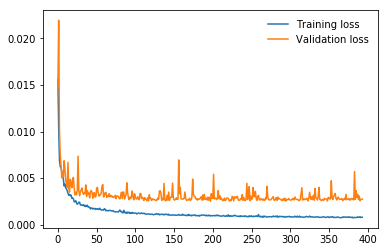

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


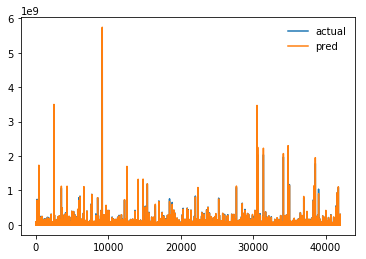

In [21]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [22]:
pred = test_func(model, X_test)


In [23]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.132997e+07
1,BTshNOJyKHnT2YIT,3.951944e+06
2,dhdymr0lV8N5kZOT,1.026775e+07
3,VEwyGGMcD56w5BOc,1.128428e+07
4,wmUeMoJZfsqaSX9b,1.960572e+06
5,EtBjGAHmHCe9t7TZ,1.960572e+06
6,hPNH34vmaZtvBtqc,1.395539e+07
7,wXjeI38bYDMJJwZC,1.176495e+07
8,fxZSGX6aPAFKU8W4,1.960572e+06
9,ewr0Fx6ign87OwaV,3.435798e+06


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true

Result 3 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->1
after 1w loss : 0.0003, test loss : 0.0007 score: 1670

Result 4 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1
train_loss: 0.0004, test loss: 0.0002 score: 1600

Result 5 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
train_loss: 0.0005, test loss: 0.003 score: 1000

Result 6 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->1 + batch_noram + weight_decay
after 2k
train_loss: 0.004, test loss 0.006 ,look like L2 regular not work which will increase loss

Result 6 lr=0.0015 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
after 3k
train_loss 0.0004 test loss 0.002 score : 1400
I think we should reduce lr or add L2 regularzation

Result 7 lr=0.0015 batch_size= 128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram + weight_decay(0.0005)
after 3.5k 
train loss 0.0007, test loss 0.002, score: 2217
regularzation is work, but test loss is not reduce, next tuning lr



### question

why output is negative?